DataFrame 'df' not found in memory. Loading from file...
Loading data from ../data/bhopal_hourly.json...
Generating advanced features (Time & Lags)...
Training Set: 650 hours
Test Set:     163 hours

Training Random Forest Regressor...
----------------------------------------
[Baseline (Persistence)] MAE: 67.14 W/m² | RMSE: 98.20 W/m²
[Random Forest       ] MAE: 24.98 W/m² | RMSE: 46.12 W/m²
----------------------------------------
Model Improvement over Baseline: 62.79%


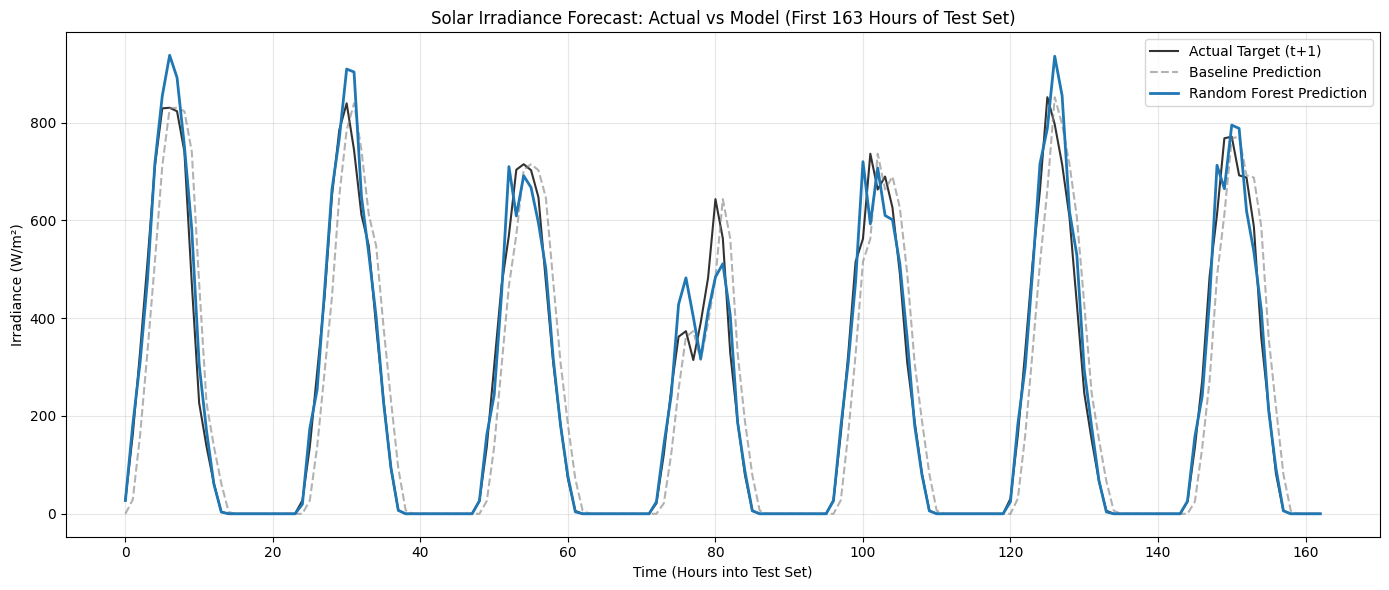

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Data Loading Configuration (Integrated for standalone execution) ---
DATA_PATH = '../data/bhopal_hourly.json'

PARAM_MAPPING = {
    'T2M': 'Temperature',
    'RELHUM2M': 'Humidity',
    'RH2M': 'Humidity',
    'ALLSKY_SFC_SW_DWN': 'Irradiance',
    'ALLSKY_KT': 'Clearness_Index',
    'CLOUD_AMT': 'Cloud_Cover',
    'WS10M': 'Wind_Speed'
}

def load_data_if_needed(file_path):
    """
    Loads data from JSON if not already present.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Data file not found at: {os.path.abspath(file_path)}")

    print(f"Loading data from {file_path}...")
    with open(file_path, 'r') as f:
        raw_data = json.load(f)

    parameters = raw_data['properties']['parameter']
    data_dict = {}
    
    for nasa_key, readable_name in PARAM_MAPPING.items():
        if nasa_key in parameters:
            series = pd.Series(parameters[nasa_key]).replace(-999, float('nan'))
            data_dict[readable_name] = series

    df = pd.DataFrame(data_dict)
    
    # Auto-detect date format
    first_idx = str(df.index[0])
    if len(first_idx) == 8: fmt = '%Y%m%d'
    elif len(first_idx) == 10: fmt = '%Y%m%d%H'
    else: fmt = None
    
    df.index = pd.to_datetime(df.index, format=fmt)
    df.index.name = 'Timestamp'
    
    # Feature Engineering for Model
    if 'Irradiance' in df.columns:
        df['Target_Next_Hour_Irradiance'] = df['Irradiance'].shift(-1)
    
    return df

def train_and_evaluate_solar_model(df):
    """
    Trains a Random Forest model and compares it against a Persistence Baseline.
    Assumes 'df' has columns: ['Temperature', 'Humidity', 'Irradiance', 'Target_Next_Hour_Irradiance']
    """
    
    # 0. Feature Engineering (Upgrades)
    print("Generating advanced features (Time & Lags)...")
    model_df = df.copy()
    
    # Upgrade 1: Time features (Cyclical encoding)
    # Encodes the 24-hour cycle so 23:00 is close to 00:00
    model_df['hour'] = model_df.index.hour
    model_df['sin_hour'] = np.sin(2 * np.pi * model_df['hour'] / 24)
    model_df['cos_hour'] = np.cos(2 * np.pi * model_df['hour'] / 24)
    
    # Upgrade 2: Lag features (Short history)
    # Gives the model momentum: what happened 1 hour ago? 2 hours ago?
    if 'Irradiance' in model_df.columns:
        model_df['irradiance_lag1'] = model_df['Irradiance'].shift(1)
        model_df['irradiance_lag2'] = model_df['Irradiance'].shift(2)
    
    # 1. Feature Selection
    # Expanded feature set
    features = [
        'Temperature', 'Humidity', 'Irradiance', 
        'sin_hour', 'cos_hour', 
        'irradiance_lag1', 'irradiance_lag2'
    ]
    target = 'Target_Next_Hour_Irradiance'
    
    # Ensure clean data
    # Check if features exist
    missing_cols = [c for c in features + [target] if c not in model_df.columns]
    if missing_cols:
        print(f"[Error] Missing columns for training: {missing_cols}")
        print("Cannot train model. Please check input data.")
        return None

    # Drop NaNs (created by lags and existing gaps)
    model_df = model_df.dropna(subset=features + [target]).copy()
    
    if len(model_df) == 0:
        print("[Error] No valid rows after dropping missing values. Cannot train.")
        return None
    
    # 2. Time-Aware Train/Test Split (80/20)
    # We do NOT shuffle because this is time-series data
    split_idx = int(len(model_df) * 0.8)
    
    X = model_df[features]
    y = model_df[target]
    
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    print(f"Training Set: {len(X_train)} hours")
    print(f"Test Set:     {len(X_test)} hours")
    
    # 3. Define Baseline Prediction (Persistence)
    # The baseline guess for t+1 is simply the irradiance at t
    y_pred_baseline = X_test['Irradiance']
    
    # 4. Train Machine Learning Model (Random Forest)
    print("\nTraining Random Forest Regressor...")
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,        # Limit depth to prevent overfitting
        random_state=42,
        n_jobs=-1            # Use all CPU cores
    )
    rf_model.fit(X_train, y_train)
    
    # Generate Predictions
    y_pred_rf = rf_model.predict(X_test)
    
    # 5. Evaluation Metrics
    def calculate_metrics(y_true, y_pred, name):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        print(f"[{name}] MAE: {mae:.2f} W/m² | RMSE: {rmse:.2f} W/m²")
        return mae, rmse

    print("-" * 40)
    base_mae, base_rmse = calculate_metrics(y_test, y_pred_baseline, "Baseline (Persistence)")
    rf_mae, rf_rmse = calculate_metrics(y_test, y_pred_rf, "Random Forest       ")
    print("-" * 40)
    
    improvement = ((base_mae - rf_mae) / base_mae) * 100
    print(f"Model Improvement over Baseline: {improvement:.2f}%")

    # 6. Visualization
    # Determine plot length (don't exceed test set size)
    target_window = 200
    plot_window = min(target_window, len(y_test))
    
    plt.figure(figsize=(14, 6))
    
    # Plot data
    plt.plot(range(plot_window), y_test.values[:plot_window], 
             label='Actual Target (t+1)', color='black', linewidth=1.5, alpha=0.8)
    plt.plot(range(plot_window), y_pred_baseline.values[:plot_window], 
             label='Baseline Prediction', color='gray', linestyle='--', alpha=0.6)
    plt.plot(range(plot_window), y_pred_rf[:plot_window], 
             label='Random Forest Prediction', color='#1f77b4', linewidth=2)
    
    plt.title(f'Solar Irradiance Forecast: Actual vs Model (First {plot_window} Hours of Test Set)')
    plt.xlabel('Time (Hours into Test Set)')
    plt.ylabel('Irradiance (W/m²)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return rf_model

# --- Execution ---
if __name__ == "__main__":
    # Check if df exists (e.g. from a previous cell), otherwise load it
    if 'df' not in locals():
        print("DataFrame 'df' not found in memory. Loading from file...")
        try:
            df = load_data_if_needed(DATA_PATH)
        except Exception as e:
            print(f"Failed to load data: {e}")
            df = pd.DataFrame() # Empty df to prevent crash in next check

    if not df.empty:
        trained_model = train_and_evaluate_solar_model(df)
    else:
        print("Detailed Error: Could not proceed with training because data could not be loaded.")